# Multiple Classifiers Ensemble System (MCS)

#### Iury Zanonni de Faria

### Imports

#### General imports

In [251]:
import pandas as pd
import numpy as np
import datetime as dt
import statistics as st
import matplotlib.pyplot as plt
import warnings

#### Feature Selection imports

In [252]:
from sklearn.feature_selection import mutual_info_classif
# Info gain - weka

#### Diversity imports

In [253]:
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

#### Classifiers imports

In [345]:
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression


#### k-mean

In [255]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

### Settings

In [256]:
DATA = ['Date', 'Current Ratio','Quick Ratio','Current Assets', 'Long-term debt to equity ratio', 'Share Holder Equity','Debt to Equity Ratio', 'Percentage of net profit to sale',
'Percentage of operating profit to sale','Percentage of Gross profit to sale','ROA','ROE','EPS','P/E','P/S','Stock book value','Stock Price','ROI','MarketReturn', 'Company']

REAL_RETURN_CLASS = "RealReturnClass"
REAL_RETURN = "RealReturn"
RISK_CLASS = 'RiskClass'
RISK = "Risk"

HIGH = 'high'
MEDIUM = 'medium'
LOW = 'low'

N_PERIODS = 2
N_FEATURES = 15

DATASET_PATH = 'dataset/process_final_reverse_{}.csv'.format(N_PERIODS)

#Remove os warnings do notebook
warnings.filterwarnings('ignore')

### Import dataset

In [257]:
dataset = pd.read_csv(DATASET_PATH)

### Data Frequency

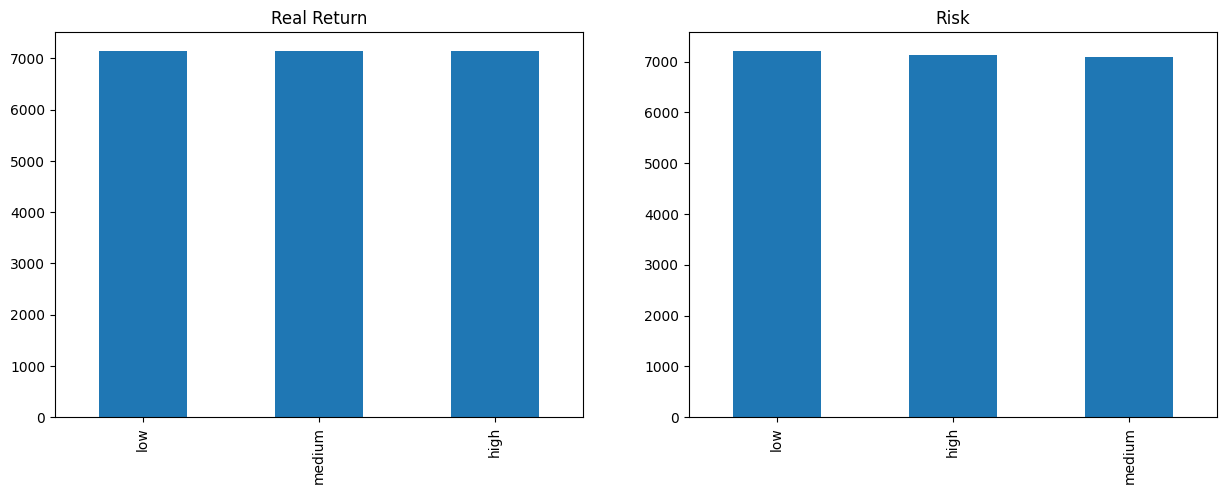

In [258]:
def plotResults(dataset:pd.DataFrame, title_1:str, title_2:str):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_figwidth(15)
  fig.set_figheight(5)

  x = dataset[REAL_RETURN_CLASS].value_counts()
  x.plot.bar(ax=axes[0])
  axes[0].set_title(title_1)

  x = dataset[RISK_CLASS].value_counts()
  x.plot.bar(ax=axes[1])
  axes[1].set_title(title_2)

plotResults(dataset, "Real Return", "Risk")

### Feature Selection

In [259]:
dataset = dataset.replace(to_replace=[HIGH], value=2.0)
dataset = dataset.replace(to_replace=[MEDIUM], value=1.0)
dataset = dataset.replace(to_replace=[LOW], value=0.0)

dataset_X = dataset.drop(columns=[REAL_RETURN_CLASS, REAL_RETURN, RISK_CLASS, RISK, "Date", "Company"])
dataset_y = dataset.drop(columns=DATA)

#### Real Return

In [260]:
rank_real_return = mutual_info_classif(dataset_X, dataset_y[REAL_RETURN_CLASS], discrete_features=True)

result_real_return = {}

for i in range(0, len(dataset_X.columns)):
    result_real_return[dataset_X.columns[i]] = rank_real_return[i]

final_ranking_real_return = sorted(result_real_return.items(), key=lambda x: x[1])
final_ranking_real_return.reverse()
final_ranking_real_return

[('ROI', 0.9990731152784823),
 ('Share Holder Equity', 0.776267081933471),
 ('Debt to Equity Ratio', 0.7571879180346832),
 ('Long-term debt to equity ratio', 0.7287167766769553),
 ('Current Assets', 0.6940743470901651),
 ('ROE', 0.6861561334985448),
 ('Stock Price', 0.6528268470057761),
 ('ROA', 0.5183829293018481),
 ('Percentage of Gross profit to sale', 0.49425270036901725),
 ('P/E', 0.381673814368316),
 ('Percentage of operating profit to sale', 0.3318492119919769),
 ('Percentage of net profit to sale', 0.3178218958379784),
 ('Stock book value', 0.310281635485454),
 ('EPS', 0.13620376393981737),
 ('P/S', 0.09124272947700807),
 ('Current Ratio', 0.07660295417457078),
 ('Quick Ratio', 0.06799106825924382),
 ('MarketReturn', 0.021849026848743593)]

#### Risk

In [261]:
rank_risk = mutual_info_classif(dataset_X, dataset_y[RISK_CLASS], discrete_features=True)

result_risk = {}

for i in range(0, len(dataset_X.columns)):
    result_risk[dataset_X.columns[i]] = rank_risk[i]

final_ranking_risk = sorted(result_risk.items(), key=lambda x: x[1])
final_ranking_risk.reverse()
final_ranking_risk

[('Share Holder Equity', 0.7703131615722059),
 ('Debt to Equity Ratio', 0.7420932960102925),
 ('Current Assets', 0.6897155169140521),
 ('Long-term debt to equity ratio', 0.6768889557248969),
 ('Stock Price', 0.6451596989064919),
 ('Percentage of Gross profit to sale', 0.4699784233599845),
 ('ROE', 0.4257423727528914),
 ('ROI', 0.34243539366855),
 ('P/E', 0.31636185082639523),
 ('Percentage of operating profit to sale', 0.3156528921372387),
 ('Percentage of net profit to sale', 0.28246911818653925),
 ('ROA', 0.21154396918680807),
 ('Stock book value', 0.18547593234084264),
 ('P/S', 0.09365007311471993),
 ('EPS', 0.0723859036467488),
 ('Current Ratio', 0.0533001549135556),
 ('Quick Ratio', 0.044979555944003755),
 ('MarketReturn', 0.019107632719523374)]

In [262]:
def getColumnsRank(rank: list):
  ranking = []
  for column in rank:
    ranking.append(column[0])
    
  return ranking

In [263]:
features_real_return = getColumnsRank(final_ranking_real_return)[:N_FEATURES]
features_risk = getColumnsRank(final_ranking_risk)[:N_FEATURES]

### SSCA

O cálculo será feito com o número total de features ou somente com as 15 mais bem ranqueadas?

In [264]:

SSCAS = []

features_return = getColumnsRank(final_ranking_real_return)[:N_FEATURES]

#dataset_X = dataset.drop(columns=[REAL_RETURN_CLASS, REAL_RETURN, RISK_CLASS, RISK, "Date", "Company"])
dataset_X = dataset[features_return]
dataset_y = dataset.drop(columns=DATA)

dataset_X

,ROI,Share Holder Equity,Debt to Equity Ratio,Long-term debt to equity ratio,Current Assets,ROE,Stock Price,ROA,Percentage of Gross profit to sale,P/E,Percentage of operating profit to sale,Percentage of net profit to sale,Stock book value,EPS,P/S
0,0.6693,71932.0,1.4824,106629.0,153154.0,1.4981,174.36,0.2875,0.4302,28.30,0.3090,0.2658,41.93,2.10,7.51
1,0.6357,63090.0,1.7294,109106.0,134836.0,1.4412,177.08,0.2760,0.4178,29.32,0.2978,0.2588,40.23,1.23,7.84
2,0.5902,64280.0,1.6452,105752.0,114423.0,1.3101,140.91,0.2582,0.4101,25.07,0.2879,0.2500,36.69,1.30,6.52
3,0.5279,69178.0,1.5705,108642.0,121465.0,1.1180,136.18,0.2291,0.3988,26.65,0.2732,0.2345,35.08,1.40,6.69
4,0.4477,66224.0,1.4992,99281.0,154106.0,0.9059,121.25,0.1944,0.3878,27.22,0.2524,0.2173,29.25,1.68,6.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21440,0.0461,11417.0,0.0239,273.0,3762.0,-0.0191,13.37,-0.0147,0.4404,0.00,0.0660,-0.0267,0.70,-0.01,0.96
21441,0.0161,11228.0,0.0239,268.0,3591.0,-0.0313,12.76,-0.0239,0.4366,0.00,0.0235,-0.0445,0.65,-0.50,0.90
21442,0.0159,11746.0,0.0321,377.0,3328.0,-0.0011,11.06,-0.0008,0.4315,0.00,0.0176,-0.0016,0.57,-0.03,0.78
21443,0.0294,11802.0,0.0313,369.0,3889.0,0.0149,13.33,0.0116,0.4298,0.00,0.0216,0.0213,0.66,0.15,0.94


In [265]:
# for cluster in range(2, 7):
#   clusterer = KMeans(n_clusters=cluster, random_state=10)

#   cluster_labels = clusterer.fit_predict(dataset_X)

#   silhouette_values = silhouette_samples(dataset_X, cluster_labels)
#   #silhouette_avg = silhouette_score(dataset_X, cluster_labels)

#   sum_count = 0
#   count_2 = 0

#   #Primeiro somatorio
#   for k in range(cluster):
#     count = 0
#     n_j = 0

#     #Segundo somatorio
#     for j in range(len(cluster_labels)):
#       if cluster_labels[j] == k:
#         n_j += 1
#         count += silhouette_values[j]

#     count_2 = (count/n_j)
#     sum_count += count_2

#   SSCA = (sum_count/cluster)
#   SSCAS.append((cluster, round(SSCA, 2)))

# SSCAS

### Divisão do dataset

In [266]:
columns_dataset = DATA
columns_dataset.append(REAL_RETURN)
columns_dataset.append(RISK)
columns_dataset.append(REAL_RETURN_CLASS)
columns_dataset.append(RISK_CLASS)

df_train = None
df_test = None

df_train = pd.DataFrame(columns=columns_dataset)
df_test = pd.DataFrame(columns=columns_dataset)

In [267]:
TRAINING_START_DATE =  dt.datetime.strptime('2009-03-31', "%Y-%m-%d")
TRAINING_END_DATE =  dt.datetime.strptime('2018-03-31', "%Y-%m-%d")

TEST_START_DATE =  dt.datetime.strptime('2018-06-30', "%Y-%m-%d")
TEST_END_DATE =  dt.datetime.strptime('2022-03-31', "%Y-%m-%d")

dataset_sort = dataset.sort_values(by='Date')
count_train = 0
count_test = 0

for index, row in dataset_sort.iterrows():
  date = dt.datetime.strptime(row['Date'], "%Y-%m-%d")
  if date.year < TEST_START_DATE.year:
    df_train = df_train.append(row)
    count_train +=1
  elif date.year == TEST_START_DATE.year and date.month < TEST_START_DATE.month:
    df_train = df_train.append(row)
    count_train +=1
  else:
    df_test = df_test.append(row)
    count_test += 1

print(count_train)
print(count_test)

df_train = df_train.drop(columns=[REAL_RETURN, RISK, "Date", "Company"])
df_test = df_test.drop(columns=[REAL_RETURN, RISK, "Date", "Company"])

# plotResults(df_train, "Real Return", "Risk")

# plotResults(df_test, "Real Return", "Risk")

14283
7162


##### Real Return

In [268]:
X_real_return_train = df_train[features_real_return]
y_real_return_train = df_train[REAL_RETURN_CLASS]

In [269]:
X_real_return_test = df_test[features_real_return]
y_real_return_test = df_test[REAL_RETURN_CLASS]

##### Risk

In [270]:
X_risk_train = df_train[features_risk]
y_risk_train = df_train[RISK_CLASS]

In [271]:
X_risk_test = df_test[features_risk]
y_risk_test = df_test[RISK_CLASS]

### Classificadores Únicos

#### Random Forest

##### Real Return

In [272]:
randon_forest_return = RandomForestClassifier(max_depth=10, random_state=42)
randon_forest_return.fit(X_real_return_train, y_real_return_train)

randon_forest_return.score(X_real_return_test, y_real_return_test)

0.9522479754258587

##### Risk

In [273]:
randon_forest_risk = RandomForestClassifier(max_depth=10, random_state=42)
randon_forest_risk.fit(X_risk_train, y_risk_train)

randon_forest_risk.score(X_risk_test, y_risk_test)

0.5034906450712091

#### SVM

##### Real Return

In [274]:
svm = SVC(kernel='rbf', C=10)
svm.fit(X_real_return_train, y_real_return_train)

svm.score(X_real_return_test, y_real_return_test)

0.509913432002234

##### Risk

In [275]:
svm = SVC(kernel='rbf', C=2)
svm.fit(X_risk_train, y_risk_train)

svm.score(X_risk_test, y_risk_test)

0.4216699246020665

#### Decision Tree

##### Real Return

In [292]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_real_return_train, y_real_return_train)

decision_tree.score(X_real_return_test, y_real_return_test)

0.9148282602624965

##### Risk

In [295]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_risk_train, y_risk_train)

decision_tree.score(X_risk_test, y_risk_test)

0.41971516336218934

#### Gaussian Naive Bayes

##### Real Return

In [306]:
nb = GaussianNB()
result = cross_val_score(nb, dataset_X, dataset_y[REAL_RETURN_CLASS], cv=10)
result.max()

0.40093240093240096

In [308]:
nb = GaussianNB()
nb.fit(X_real_return_train, y_real_return_train)

nb.score(X_real_return_test, y_real_return_test)

0.4120357442055292

##### Risk

In [279]:
nb_risk = GaussianNB()
nb_risk.fit(X_risk_train, y_risk_train)

nb_risk.score(X_risk_test, y_risk_test)

0.34068695895001394

#### Rede Neural

##### Real Return

In [338]:
neural_return = MLPClassifier(alpha=1)
neural_return.fit(X_real_return_train, y_real_return_train)

neural_return.score(X_real_return_test, y_real_return_test)

0.5194079865959229

##### Risk

In [343]:
neural_risk = MLPClassifier(alpha=1, max_iter=500, random_state=42)
neural_risk.fit(X_risk_train, y_risk_train)

neural_risk.score(X_risk_test, y_risk_test)

0.4361910080982966

#### Regressão Logística

##### Real Return

In [375]:
rl_return = LogisticRegression(solver='newton-cg', penalty='l2')
rl_return.fit(X_real_return_train, y_real_return_train)

rl_return.score(X_real_return_test, y_real_return_test)

0.8781066741133762

##### Risk

In [372]:
rl_risk = LogisticRegression( solver='newton-cholesky')
rl_risk.fit(X_risk_train, y_risk_train)

rl_risk.score(X_risk_test, y_risk_test)

0.44205529181792796